In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [31]:
data = pd.read_csv('./OptionMetrics/options2223.csv', nrows=10_000)

In [32]:
print(data.head())

    secid        date              symbol      exdate last_date cp_flag  \
0  100219  2022-01-03  RUI 220121C1750000  2022-01-21       NaN       C   
1  100219  2022-01-03  RUI 220121C1775000  2022-01-21       NaN       C   
2  100219  2022-01-03  RUI 220121C1800000  2022-01-21       NaN       C   
3  100219  2022-01-03  RUI 220121C1825000  2022-01-21       NaN       C   
4  100219  2022-01-03  RUI 220121C1850000  2022-01-21       NaN       C   

   strike_price  best_bid  best_offer  volume  open_interest  impl_volatility  \
0       1750000     895.5       919.5       0              0              NaN   
1       1775000     870.5       894.5       0              0              NaN   
2       1800000     845.5       869.5       0              0              NaN   
3       1825000     820.5       844.5       0              0              NaN   
4       1850000     795.5       819.5       0              0              NaN   

    optionid  contract_size  forward_price  expiry_indicator  

In [33]:
sample = data[(data['secid']==100219) & (data['date']=='2022-01-03') & (data['exdate'] =='2022-02-18') & (data['cp_flag']=='C')]

In [34]:
forwards = pd.read_csv('./OptionMetrics/forwards2223.csv')

KeyboardInterrupt: 

In [ ]:
forwards[(forwards['secid']==100219) & (forwards['date']=='2022-01-03') & (forwards['expiration'] == '2022-02-18')]

,secid,date,expiration,ForwardPrice,ticker
10630,100219,2022-01-03,2022-02-18,2662.556214,RUI
10631,100219,2022-01-03,2022-02-18,2662.516513,RUI


In [ ]:
securities = pd.read_csv('./OptionMetrics/securities2223.csv', nrows=10_000)

In [ ]:
securities[(securities['secid']==100219) & (securities['date']=='2022-01-03')]

,secid,date,ticker,sic,index_flag,exchange_d,low,high,open,close,volume
6953,100219,2022-01-03,RUI,9999.0,1,32768,2640.25,2660.95,2645.68,2660.78,0


In [ ]:
rates = pd.read_csv('./OptionMetrics/rates2223.csv', nrows=10_000)

In [ ]:
rates.head()

,date,days,rate
0,2022-01-03,10,0.518382
1,2022-01-03,30,0.524269
2,2022-01-03,60,0.534101
3,2022-01-03,91,0.545490
4,2022-01-03,122,0.558093


In [ ]:
rates[(rates['date'] == '2022-01-03') & (rates['days']==10)]['rate'][0] / 100

0.0051838200000000004

In [ ]:
import pipeline
import importlib
importlib.reload(pipeline)
R = 0.000524269 # Rate for 30 day
S = 2640.25 # We take low price to avoid impl vol calc issues
processed = sample[['strike_price', 'best_bid', 'best_offer', 'impl_volatility']]
processed['strike_price'] = processed['strike_price'] / 1000
T = 45 / 365
R = R / T
processed['vol_high'] = processed.apply(lambda x: pipeline.implied_vol(x['best_offer'], S, x['strike_price'], T, R), axis=1)
processed['vol_low'] = processed.apply(lambda x: pipeline.implied_vol(x['best_bid'], S, x['strike_price'], T, R), axis=1)
processed['vol_mid'] = (processed['vol_high'] + processed['vol_low']) / 2

C:\Users\User\AppData\Local\Temp\ipykernel_16708\305534099.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed['strike_price'] = processed['strike_price'] / 1000
C:\Users\User\AppData\Local\Temp\ipykernel_16708\305534099.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed['vol_high'] = processed.apply(lambda x: pipeline.implied_vol(x['best_offer'], S, x['strike_price'], T, R), axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_16708\305534099.py:11: SettingWithCopyWarning: 
A value is t

In [ ]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also

#     display(processed)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

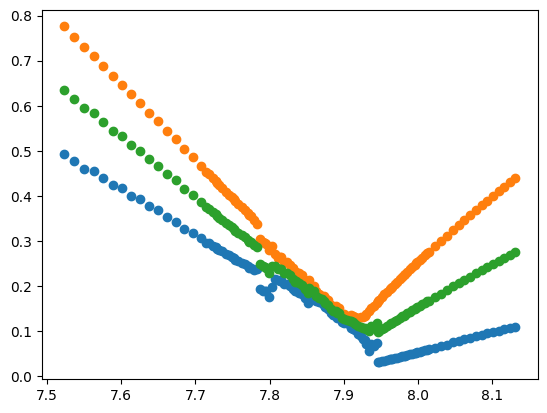

In [ ]:
plt.scatter(processed['strike_price'].apply(np.log), processed['vol_low'])
plt.scatter(processed['strike_price'].apply(np.log), processed['vol_high'])
plt.scatter(processed['strike_price'].apply(np.log), processed['vol_mid'])

In [ ]:
import smilecorrector as smilenet
importlib.reload(smilenet)
import torch
importlib.reload(torch)
# For first try, we pass our boundaries as each strike price

boundaries = processed['strike_price'].apply(np.log).to_numpy()
ind = np.array([i for i in range(0,boundaries.shape[0],20)])
boundaries = boundaries[ind]
strikes = boundaries.copy()
# boundaries = np.hstack([np.array([(1 - i/10) * hi + i/10 * lo for i in range(11)]) for hi, lo in zip(boundaries[:-1], boundaries[1:])])
mids = processed['vol_mid'].to_numpy()[ind]
print(' Boundary shape' , boundaries.shape)
print('Mid shape', mids.shape)
print('Strike shape', strikes.shape)
model = smilenet.SmileNet(boundaries, strikes, mids)

TypeError: all() received an invalid combination of arguments - got (generator), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, tuple of ints dim, bool keepdim, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, Tensor out)
 * (Tensor input, name dim, bool keepdim, *, Tensor out)


In [ ]:
datum = torch.tensor(np.vstack([processed['vol_high'].to_numpy()[ind].reshape(-1,1), processed['vol_low'].to_numpy()[ind].reshape(-1,1)])).double()
print('Datum shape: ', datum.shape)
print(model.xstar.shape)
print(model.blackbox[-1])
print(model.translate.shape)
res1 = model.forward(datum.T.double())
res1 = res1.reshape(-1)
# print(res1.shape)
# print(res1)

NameError: name 'ind' is not defined

In [ ]:
print(len(boundaries))
boundary_spaces = [np.linspace(x,y) for x, y in zip(boundaries[:-1],boundaries[1:])]
resn = res1.detach().numpy()
print(resn.shape)
polys = [np.polynomial.polynomial.Polynomial(list(reversed(resn[4*i:4*i+4]))) for i in range(resn.shape[0]//4)]
print(len(polys), len(boundary_spaces)) # Why am I throwing away the first polynomial
polys = polys[:]
print(len(polys), len(boundary_spaces))
plot_points = np.hstack([poly(space) for poly, space in zip(polys, boundary_spaces)])
print(len(plot_points))
points = np.hstack(boundary_spaces)
print(len(points))

NameError: name 'boundaries' is not defined

In [ ]:
print(boundaries[0])
print(np.log(processed['strike_price'].to_numpy()[0]), processed['vol_mid'].to_numpy()[0])
print(resn[0:4])

NameError: name 'boundaries' is not defined

In [ ]:
plt.plot(points, plot_points)
plt.scatter(processed['strike_price'].apply(np.log), processed['vol_low'])
plt.scatter(processed['strike_price'].apply(np.log), processed['vol_high'])
plt.scatter(processed['strike_price'].apply(np.log), processed['vol_mid'])

NameError: name 'points' is not defined

In [ ]:
import smilecorrector as smilenet
import torch
importlib.reload(smilenet)
# For first try, we pass our boundaries as each strike price
boundaries = processed['strike_price'].apply(np.log).to_numpy()
ind = np.array([i for i in range(0,boundaries.shape[0],3)])
boundaries = boundaries[ind]
strikes = boundaries.copy()
log_strikes = torch.tensor(processed['strike_price'].apply(np.log).to_numpy())
mids = np.sqrt((processed['vol_mid'].to_numpy() + processed['vol_mid'].to_numpy())/2)[ind]
print(' Boundary shape' , boundaries.shape)
print('Mid shape', mids.shape)
print('Strike shape', strikes.shape)
model = smilenet.SmileNet(boundaries, log_strikes, mids)
datum = torch.tensor(np.vstack([np.sqrt(processed['vol_high'].to_numpy().reshape(-1,1)), np.sqrt(processed['vol_low'].to_numpy().reshape(-1,1))])).double()
model.train(datum.T.double(), log_strikes)

 Boundary shape (42,)
Mid shape (42,)
Strike shape (42,)
Strike knots shape 42
System shape: (120, 164) With 40 knots
(164, 44) (120, 164) (164, 1)
(164, 1)
(164, 44)
(44, 1)
torch.Size([44])
Epoch: 0


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\polynomial\polyutils.py:577: RuntimeWarning: invalid value encountered in add
  c1[:c2.size] += c2
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\polynomial\polyutils.py:590: RuntimeWarning: invalid value encountered in subtract
  c1[:c2.size] -= c2
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\polynomial\polynomial.py:1401: RuntimeWarning: invalid value encountered in divide
  mat[:, -1] -= c[:-1]/c[-1]


LinAlgError: Array must not contain infs or NaNs

In [ ]:
res1 = model.forward(datum.T.double())
res1 = res1.reshape(-1)

print(len(boundaries))
boundary_spaces = [np.linspace(x,y) for x, y in zip(boundaries[:-1],boundaries[1:])]
resn = res1.detach().numpy()
print(resn.shape)
polys = [np.polynomial.polynomial.Polynomial(list(reversed(resn[4*i:4*i+4]))) for i in range(resn.shape[0]//4)]
print(len(polys), len(boundary_spaces)) # Why am I throwing away the first polynomial
polys = polys[:]
print(len(polys), len(boundary_spaces))
plot_points = np.hstack([poly(space) for poly, space in zip(polys, boundary_spaces)])
print(len(plot_points))
points = np.hstack(boundary_spaces)
print(len(points))
plt.plot(points, plot_points)
plt.scatter(processed['strike_price'].apply(np.log), processed['vol_low'])
plt.scatter(processed['strike_price'].apply(np.log), processed['vol_high'])
plt.scatter(processed['strike_price'].apply(np.log), processed['vol_mid'])

NameError: name 'datum' is not defined

In [ ]:
import datetime
importlib.reload(pipeline)
dts = lambda x: datetime.datetime.strftime(x, "%Y-%m-%d")
std = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d")
dt100219 = []
d = std("2022-01-03")
date_end = std("2022-01-12")
dt = datetime.timedelta(days=1)
# while d <= date_end:
data = data[data['best_bid'] != 0]
counts = data[(data['date'] == dts(d+ 2 *dt)) & (data['cp_flag'] == 'C')].groupby('exdate',as_index=False).count()
for i in counts[counts['secid'] > 100]['exdate']:
    T = (std(i) - d).days / 365
    R = 0.0053 # Arb for now
    S = securities[(securities['date'] == dts(d)) & (securities['secid']==100219)]['low'].iloc[0]
    data_in = data[(data['date'] == dts(d+ 2 *dt)) & (data['cp_flag'] == 'C') & (data['exdate'] == i)].sample(100)
    print(data_in)
    print(S, T, R)
    dt100219 += [pipeline.get_datum(data_in,S, T, R)]
    d += dt
    

       secid        date              symbol      exdate last_date cp_flag  \
3407  100219  2022-01-05  RUI 220318C2370000  2022-03-18       NaN       C   
3385  100219  2022-01-05  RUI 220318C2180000  2022-03-18       NaN       C   
3429  100219  2022-01-05  RUI 220318C2550000  2022-03-18       NaN       C   
3366  100219  2022-01-05  RUI 220318C2025000  2022-03-18       NaN       C   
3364  100219  2022-01-05  RUI 220318C2010000  2022-03-18       NaN       C   
...      ...         ...                 ...         ...       ...     ...   
3433  100219  2022-01-05  RUI 220318C2625000  2022-03-18       NaN       C   
3440  100219  2022-01-05  RUI 220318C2800000  2022-03-18       NaN       C   
3399  100219  2022-01-05  RUI 220318C2300000  2022-03-18       NaN       C   
3404  100219  2022-01-05  RUI 220318C2340000  2022-03-18       NaN       C   
3374  100219  2022-01-05  RUI 220318C2090000  2022-03-18       NaN       C   

      strike_price  best_bid  best_offer  volume  open_interest

d:\Project\pipeline.py:7: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
d:\Project\pipeline.py:12: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
d:\Project\pipeline.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  sigma = max(sigma + diff/vega, PRECISION) # f(x) / f'(x)
d:\Project\pipeline.py:7: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
d:\Project\pipeline.py:12: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
d:\Project\pipeline.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

KeyboardInterrupt: 

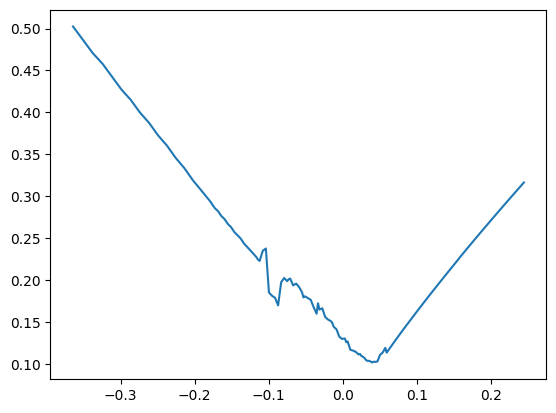

In [ ]:
plt.plot(log_strikes, torch.sqrt(mids))

1
tensor([-0.3641, -0.3507, -0.3374, -0.3244, -0.3115, -0.2987, -0.2861, -0.2737,
        -0.2614, -0.2493, -0.2373, -0.2255, -0.2138, -0.2023, -0.1908, -0.1795,
        -0.1728, -0.1684, -0.1639, -0.1595, -0.1573, -0.1551, -0.1507, -0.1464,
        -0.1420, -0.1377, -0.1356, -0.1334, -0.1291, -0.1249, -0.1206, -0.1164,
        -0.1143, -0.1122, -0.1080, -0.1038, -0.0997, -0.0955, -0.0935, -0.0914,
        -0.0873, -0.0832, -0.0791, -0.0751, -0.0730, -0.0710, -0.0670, -0.0630,
        -0.0590, -0.0550, -0.0530, -0.0511, -0.0471, -0.0432, -0.0393, -0.0354,
        -0.0334, -0.0315, -0.0276, -0.0238, -0.0199, -0.0161, -0.0142, -0.0123,
        -0.0085, -0.0047, -0.0010,  0.0028,  0.0047,  0.0065,  0.0103,  0.0140,
         0.0177,  0.0213,  0.0232,  0.0250,  0.0287,  0.0323,  0.0359,  0.0396,
         0.0414,  0.0432,  0.0468,  0.0503,  0.0539,  0.0575,  0.0592,  0.0610,
         0.0645,  0.0680,  0.0715,  0.0750,  0.0768,  0.0785,  0.0820,  0.0854,
         0.0889,  0.0923,  0.0940,  0.

KeyboardInterrupt: 

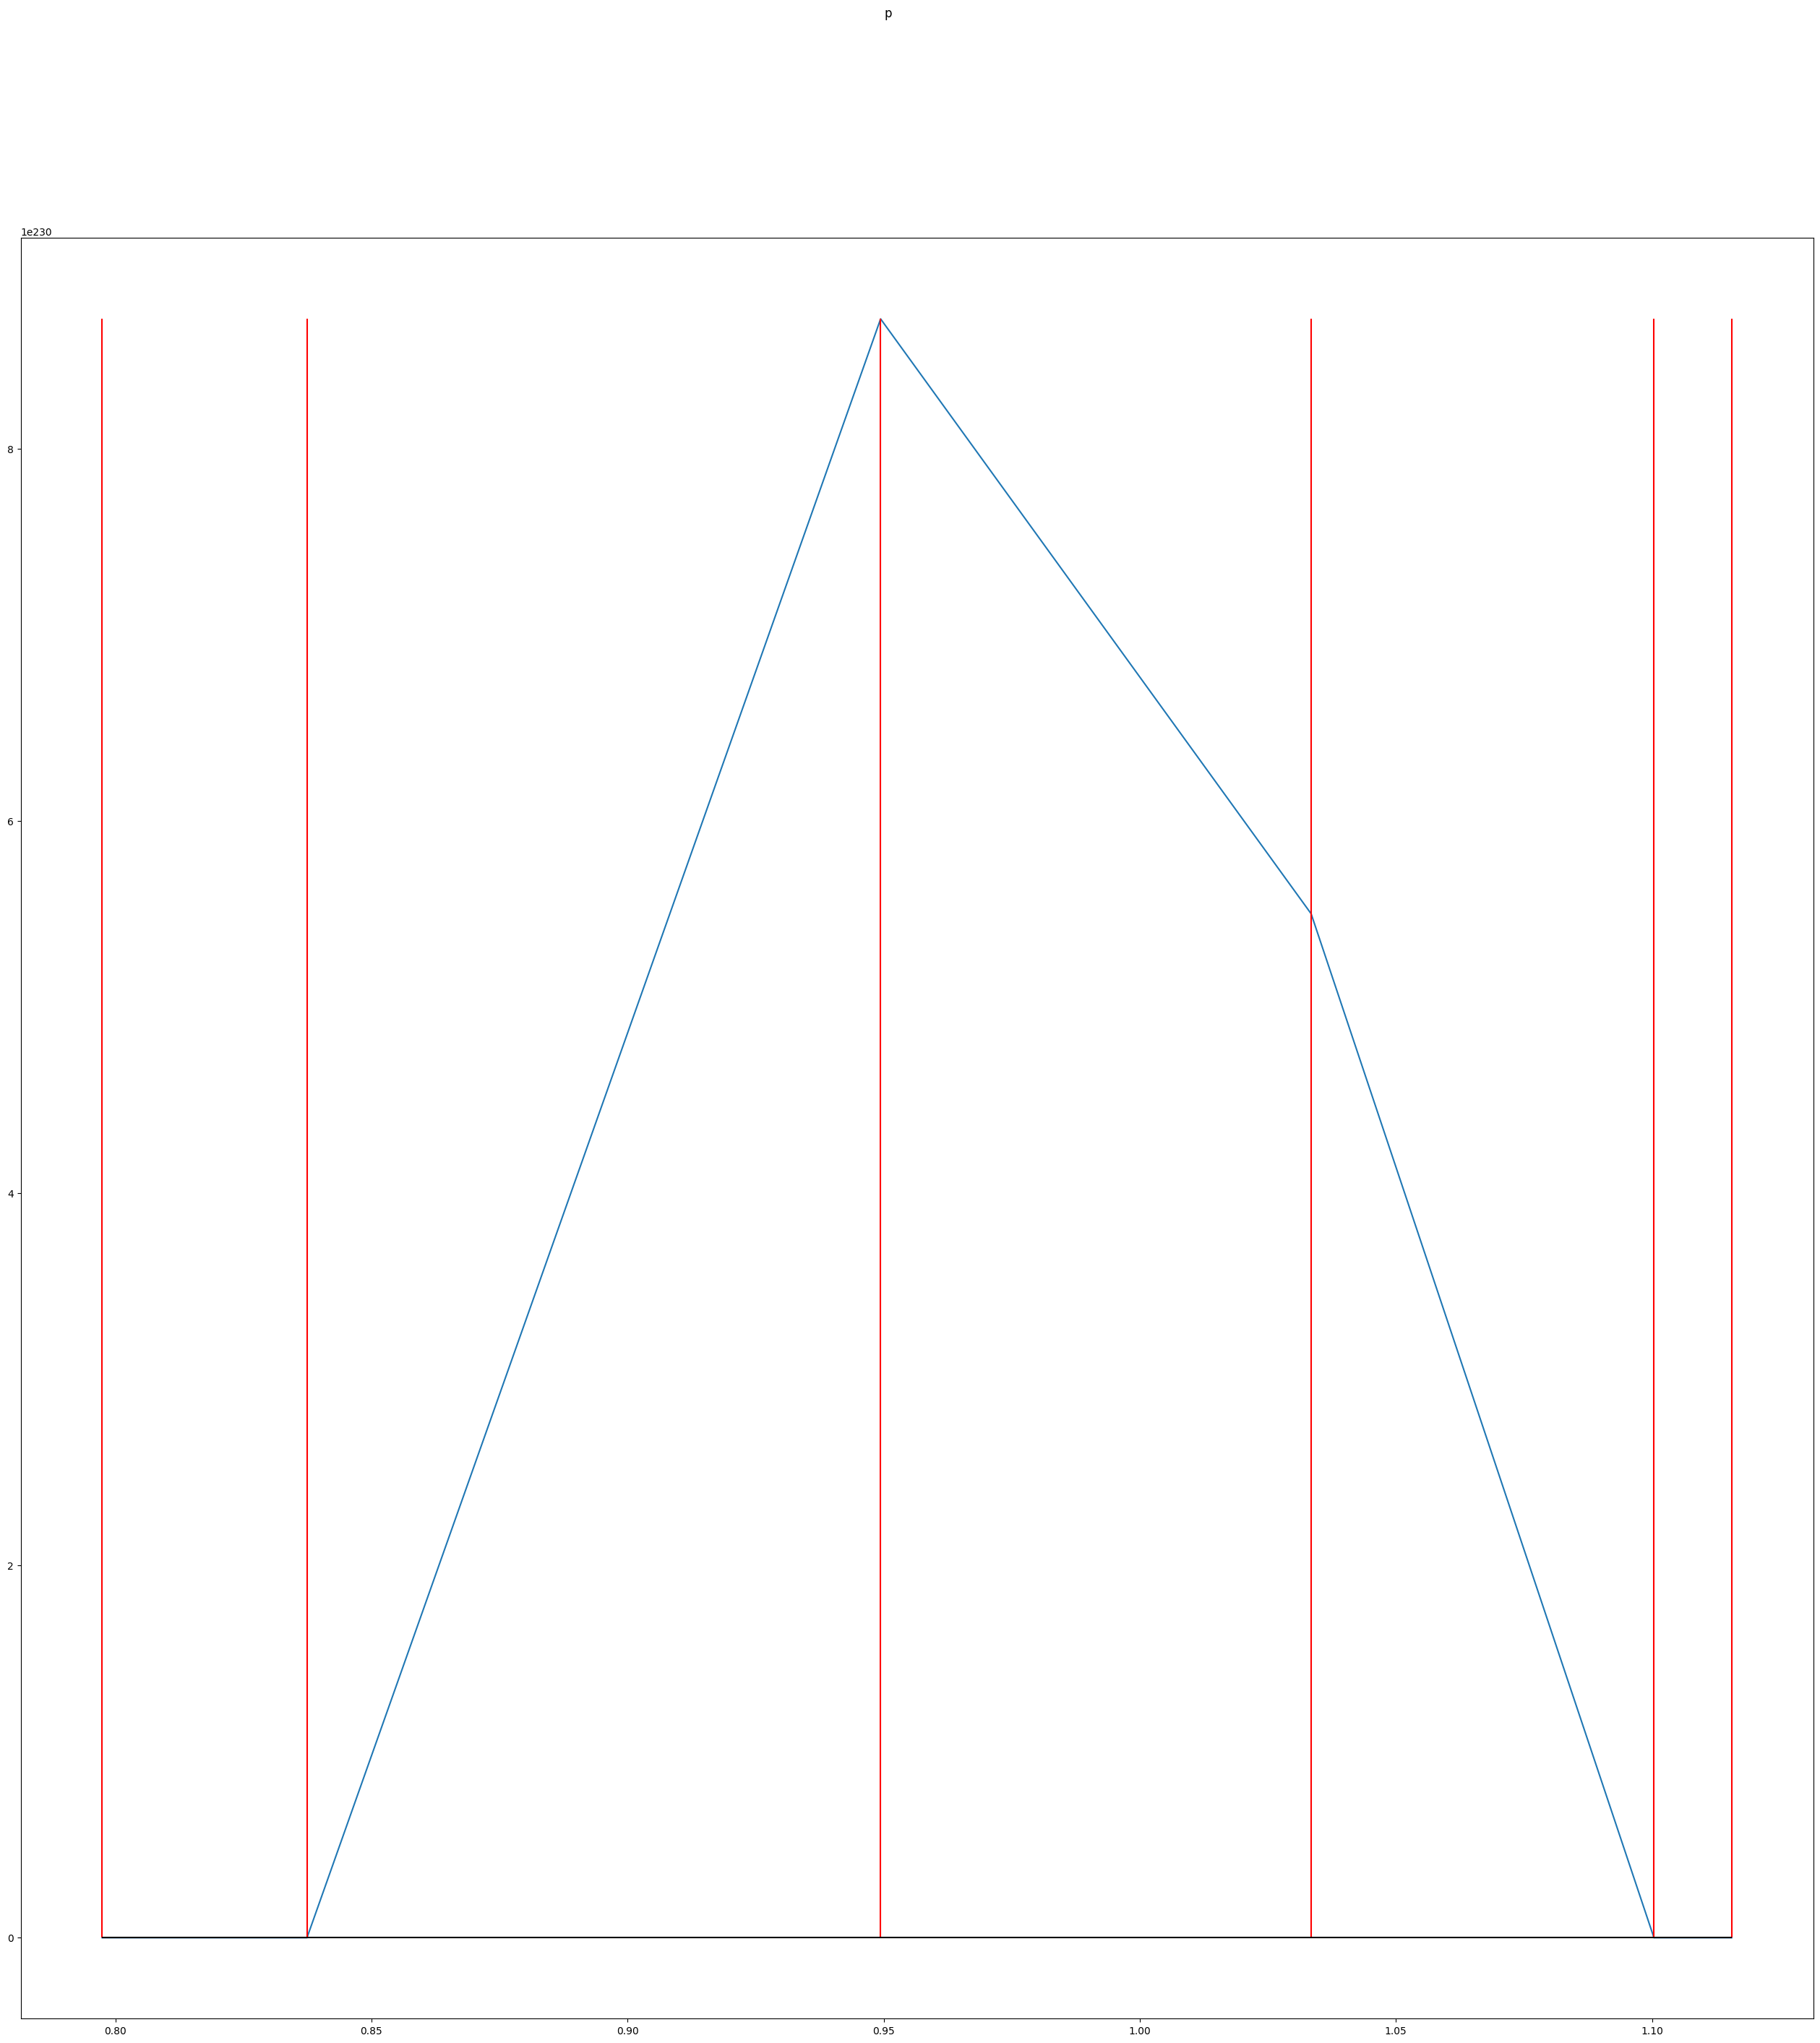

In [49]:
import smilecorrector_qr_root as smilenet
import torch
importlib.reload(smilenet)
# For first try, we pass our boundaries as each strike price
# boundaries = processed['strike_price'].apply(np.log).to_numpy()
# ind = np.array([i for i in range(0,boundaries.shape[0],3)])
# boundaries = boundaries[ind]
# strikes = boundaries.copy()
S = 2640.25 # We take low price to avoid impl vol calc issues
T = 1#45 / 365
R = 0.000524269 # Rate for 30 day - Question on unit / order of magnitude
F = 2662.556214
print(T)
log_strikes = torch.tensor((processed['strike_price'].apply(np.log).to_numpy()- np.log(F))) #   
print(log_strikes)
S = torch.tensor(S).reshape(1,1)
T = torch.tensor(T).reshape(1,1)
R = torch.tensor(R).reshape(1,1)
mids = torch.tensor(((processed['vol_high'].to_numpy() ** 2 + processed['vol_low'].to_numpy() ** 2) / 2))
# mids = mids * T
print(mids.shape)
mids = mids * T.item() 
print(mids.shape)
print('Mid shape', mids.shape)
his = T.item() * (processed['vol_high']).to_numpy().reshape(-1,1) ** 2
los = T.item() * (processed['vol_low']).to_numpy().reshape(-1,1) ** 2
# datum, log_strikes = pipeline.get_datum('2022-0') 
model = smilenet.SmileNet(4, log_strikes, mids)
datum = torch.tensor(np.vstack([ his , los , log_strikes.reshape(-1,1), np.log(S), T, R])).double()
print(log_strikes.shape, datum.shape)
print(datum.T.shape)
model.train(datum.T.double(), log_strikes, epochs=100)

In [ ]:
linear_g = np.polynomial.polynomial.Polynomial(smilenet.transform(torch.tensor([[1,1]]))[0][:])
print(linear_g)
smilenet.plot_polys([linear_g], torch.tensor([-1,1]),0,'test' )

2.75 + 2.5 x + 0.75 x**2 + 0.0 x**3 + 0.0 x**4 + 0.0 x**5 + 0.0 x**6


In [ ]:

norm = smilenet.differentiableNormCdf.apply

def d_plus(k, w):
    kreal = k - 1
    return -kreal / torch.sqrt(w(k)) + torch.sqrt(w(k)) / 2
def d_sub(k,w):
    kreal = k - 1
    return -kreal / torch.sqrt(w(k)) - torch.sqrt(w(k)) / 2


def bsc_svi(k, w, S):
    kreal = k - 1
    return S * (norm(d_plus(k, w)) - torch.exp(kreal) * norm(d_sub(k, w)))

In [ ]:
from functools import partial
pred, boundaries = model.forward(datum.T.double())
ttensor = smilenet.transform(pred.detach(),1.0)
polys = [np.polynomial.polynomial.Polynomial(torch.flip((pred[:,0][4*i:4*i+4]), dims=(0,)).detach().numpy()) for i in range((pred.shape[0])//4)]
ts = [np.polynomial.polynomial.Polynomial(ttensor[i,:]) for i in range(ttensor.shape[0])]

funcs = [partial(bsc_svi, w = polys[i], S=S) for i in range(len(polys))]

boundaries = torch.hstack([torch.tensor(log_strikes[0]), boundaries.reshape(-1), torch.tensor(log_strikes[-1])])
his = torch.tensor(his).reshape(-1)
los = torch.tensor(los).reshape(-1)
print(los[0], log_strikes[0], mids[0])
print(type(mids), type(his))
ppm = [bsc_svi(log_strikes[i], lambda k, const=mids[i]: const, S) for i in range(log_strikes.reshape(-1).shape[0])]
pph = [bsc_svi(log_strikes[i], lambda k, const=his[i]: const, S) for i in range(log_strikes.reshape(-1).shape[0])]
ppl = [bsc_svi(log_strikes[i], lambda k, const=los[i]: const, S) for i in range(log_strikes.reshape(-1).shape[0])]


print(boundaries.shape)

smilenet.plot_polys(funcs, boundaries, 0, 'bs', extra_points=[(log_strikes, processed['best_offer'].to_numpy(), 'raw low'), (log_strikes, processed['best_bid'].to_numpy(), 'raw high'), (log_strikes, ppm, 'calc mid'), (log_strikes, pph, 'calc hi'),(log_strikes, ppl, 'calc lo')], labels=True)


With remaining arb: 6.205683511738887e-05 over 99 epochs


C:\Users\User\AppData\Local\Temp\ipykernel_7080\3372290018.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boundaries = torch.hstack([torch.tensor(log_strikes[0]), boundaries.reshape(-1), torch.tensor(log_strikes[-1])])


tensor(0.0300) tensor(0.6359) tensor(0.0521)
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([9])


In [ ]:
# Play with SmileCorrect
import smilecorrector as sc
importlib.reload(sc)
control = torch.tensor(model.translate @ model.xstar).reshape(1,-1).double()
# control = torch.zeros(control.shape)
control.requires_grad_()
translate = model.translate

boundaries = model.boundaries
print(model.boundaries.shape, res1.shape)
sol, loss = sc.remove_arb(control, translate, boundaries)
print(control.shape)
print(sol.shape)
print('Loss of', loss)
loss2 = torch.sum(torch.abs(sol))
print("l1 of", loss2)

print(torch.autograd.grad(loss2, control))
polys = [np.polynomial.polynomial.Polynomial(list(reversed(sol[:,0].detach().numpy()[4*i:4*i+4]))) for i in range((sol.shape[0])//4)]
sc.plot_polys(polys, boundaries, 0, 'test')


C:\Users\User\AppData\Local\Temp\ipykernel_5392\2442275951.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  control = torch.tensor(model.translate @ model.xstar).reshape(1,-1).double()


(42,) torch.Size([164])
With remaining arb: 4.336808689942018e-11


ValueError: too many values to unpack (expected 2)

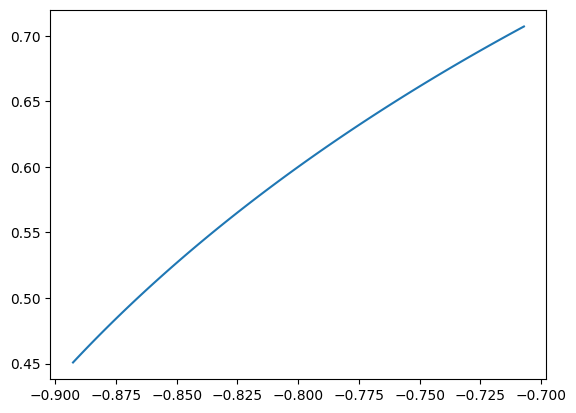

In [ ]:
import matplotlib.pyplot as plt
import torch 

a = torch.tensor([[1,2]]).T.double()
xs = []
ys = []
for i in range(100):
    a[0,0] = a[0,0] + 0.01
    q, r = torch.linalg.qr(a, mode='complete')
    xs += [q[0,1]]
    ys += [q[1,1]]
plt.plot(xs, ys)

In [ ]:
xs = torch.normal(0, torch.ones(3,1))
xs = (xs / xs.norm(dim=0)).T
print(xs.shape)
for i in xs:
    print("(%s, %s, %s)" % (i[0].item(), i[1].item(), i[2].item()))
    print(torch.linalg.norm(i))

print(xs)

torch.Size([1, 3])
(-0.8903900384902954, -0.358125239610672, -0.2809835374355316)
tensor(1.0000)
tensor([[-0.8904, -0.3581, -0.2810]])


In [ ]:
v = torch.tensor((0.3009892404079437, 0.02299308031797409, -0.9533502459526062))

In [ ]:
Q, _ = torch.linalg.qr(torch.tensor([[1,-1,0],[0,1,-1]]).T.double())

In [ ]:
print(Q)

tensor([[-0.7071, -0.4082],
        [ 0.7071, -0.4082],
        [-0.0000,  0.8165]], dtype=torch.float64)


In [ ]:
v = torch.tensor([[1,0.5,2.0],[2,3,1]]).T.double()
print(v - Q @ (Q.T @ v))

tensor([[1.1667, 2.0000],
        [1.1667, 2.0000],
        [1.1667, 2.0000]], dtype=torch.float64)
